In [1]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
import subprocess
from transformers import AutoModel, pipeline, Trainer, AutoTokenizer
import json
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

c:\GitHub\PRPR\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [4]:
sampling_strategy = 1.0
rsmpl = RandomUnderSampler(sampling_strategy=sampling_strategy)

In [5]:

from tree_sitter import Language, Parser


CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')

parser = Parser()
parser.set_language(CPP_LANGUAGE)

c:\GitHub\PRPR\.venv\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [6]:
def get_index_code_dict(emb_ds):
    res_dict = {}
    
    for el in emb_ds:
        res_dict[el["index"]] = el["embedding"]
        
    return res_dict
    

In [7]:
#эмбеддинги для батча
def get_embeddings(inputs, model):
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

In [8]:
def get_pairs_ds(emb_ds):
    id = 0
    print(len(emb_ds))
    id_1 = []
    id_2 = []
    is_same = []
    same_class = []
    for i in range(len(emb_ds)-1):
        id += 1
        if id % 100 == 0 or id == 10:
            print(id)
        for j in range(i+1, len(emb_ds)):
            id_1.append(i)
            id_2.append(j)
            are_same = emb_ds[i]["label"] == emb_ds[j]["label"]
            is_same.append(int(are_same))
            if are_same:
                same_class.append(emb_ds[i]["label"])
            else:
                same_class.append(-100)

    dataset = Dataset.from_dict({ "id_1":id_1,"id_2": id_2,
                                    "is_same": is_same, "same_class": same_class})
    return dataset

In [9]:
        
def get_similarities_ds(emb_ds, resampled_ds):
    X = []
    y = []
    for el in resampled_ds:
        conc_tensor = torch.cat([
            torch.Tensor(emb_ds[el["id_1"]]["embeddings"]),
            torch.Tensor(emb_ds[el["id_2"]]["embeddings"]),
            torch.Tensor(pairwise_distances(emb_ds[el["id_1"]]["embeddings"],emb_ds[el["id_2"]]["embeddings"],
                                                   metric='cosine'))
        ], dim=1)
        X.append(conc_tensor.view(-1))
        y.append(el["is_same"])
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.3, stratify=y, random_state=49)
    
    X_eval, X_test, y_eval, y_test = train_test_split(X_t, y_t, test_size=0.7, random_state=64)
    return X_train, X_eval, X_test, y_train, y_eval, y_test
        

In [10]:
def get_accuracy(emb_dataset):
    index_1 = []
    index_2 = []
    code_1 = []
    code_2 = []
    is_clones = []
    similarities = []
    for i in range(len(emb_dataset) - 1):
        i_label = emb_dataset[i]["label"]
        i_embeddings = torch.Tensor(emb_dataset[i]["embedding"][0]).reshape([1, -1])
        
        if i % 10 == 0:
            print(i)
            
        for j in range(i+1, len(emb_dataset)):
            j_label = emb_dataset[j]["label"]
            j_embeddings = torch.Tensor(emb_dataset[j]["embedding"][0]).reshape([1, -1])
            
            similarity = pairwise_distances(i_embeddings,j_embeddings,
                                                   metric='fgh')
            
            index_1.append(emb_dataset[i]["index"])
            index_2.append(emb_dataset[j]["index"])
            code_1.append(emb_dataset[i]["res_code"])
            code_2.append(emb_dataset[j]["res_code"])
            is_clones.append(int(emb_dataset[i]["label"] == emb_dataset[j]["label"]))
            similarities.append(similarity)
            
    acc_dataset = Dataset.from_dict({ "index_1":index_1,"index_2": index_2, "is_clones": is_clones,
                                "similarities": similarities})
    return acc_dataset
            
    
    

In [11]:
from collections import deque

def get_tokenized_dataset_json_w_code_ch(datafile, model):
    index = []
    label = []
    code = []
    code_1 = []
    code_2 = []
    bin_labels = []

    input_ids_1 = []
    input_ids_2 = []
    att_mask_1 = []
    att_mask_2 = []
    embeddings = []

    cnt = 0
    with open(datafile) as file:
            for line in file.readlines():
                cntr = 0
                res_str = ""
                cnt += 1   
                if cnt%100==0:
                    print(cnt)
                
                json_line = json.loads(line)
                index.append(int(json_line["index"]))
                label.append(int(json_line["label"]) - 1)
                clear_code = json_line["code"].replace("\r", "").replace("\n","").replace("\t","")
                
                tree = parser.parse(bytes(clear_code, 'utf8'))
                res_str += "{"
                cntr += 1
                queue = deque([tree.root_node, None])
                
                while queue:
                    node = queue.popleft()
                                       
                    if node is not None:
                        pr_t = node.parent.type if node.parent is not None else None
                        res_str += f"({node.type},{pr_t})"
                        for child in node.children:
                            queue.append(child)
                    else:
                        res_str += "{"    
                        cntr += 1
                                 
                    
                for i in range (cntr):
                    res_str += "}"

                result = clear_code + res_str
                code.append(result)
                
                
                embeddings.append(get_embeddings(tokenizer(result, max_length = 512, truncation=True, pad_to_max_length=True,  return_tensors='pt'), model))

    dataset = Dataset.from_dict({ "res_code":code,"index": index, 
                                 "embeddings": embeddings,
                                "label": label})
    return dataset

In [12]:
rsm_test_json_w_code = get_tokenized_dataset_json_w_code_ch("rsm_test.jsonl", model)
rsm_test_json_w_code.to_json("rsm_test_json_w_code.jsonl")

c:\GitHub\PRPR\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


100
200
300
400
500
600
700
800
900
1000
1100
1200


Creating json from Arrow format: 100%|██████████| 2/2 [00:00<00:00,  7.30ba/s]


23656174

In [13]:
rsm_test_json_w_code = load_dataset("json", data_files="rsm_test_json_w_code.jsonl")["train"]

Generating train split: 1200 examples [00:00, 13636.10 examples/s]


In [14]:


rsm_test_json_w_code_pairs = get_pairs_ds(rsm_test_json_w_code)
rsm_test_json_w_code_pairs.to_json("rsm_test_json_w_code_pairs.jsonl")

1200
10
100
200
300
400
500
600
700
800
900
1000
1100


Creating json from Arrow format: 100%|██████████| 720/720 [00:00<00:00, 815.18ba/s]


38846610

In [15]:
rsm_test_json_w_code_pairs

Dataset({
    features: ['id_1', 'id_2', 'is_same', 'same_class'],
    num_rows: 719400
})

In [16]:
X = pd.DataFrame({"id_1": rsm_test_json_w_code_pairs["id_1"], "id_2": rsm_test_json_w_code_pairs["id_2"], "same_class": rsm_test_json_w_code_pairs["same_class"]})

y = rsm_test_json_w_code_pairs["is_same"]

X_resampled, y_resampled = rsmpl.fit_resample(X, y)

rsm_test_json_w_code_pairs = Dataset.from_pandas(X_resampled)

rsm_test_json_w_code_pairs = rsm_test_json_w_code_pairs.add_column("is_same", y_resampled)

rsm_test_json_w_code_pairs.to_json("rsm_test_json_w_code_pairs.jsonl")

Creating json from Arrow format: 100%|██████████| 119/119 [00:00<00:00, 555.68ba/s]


9516372

In [17]:
rsm_test_json_w_code_pairs

Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [18]:
rsm_test_json_w_code_pairs = load_dataset("json", data_files="rsm_test_json_w_code_pairs.jsonl")["train"]
rsm_test_json_w_code_pairs

Generating train split: 118800 examples [00:00, 2329504.37 examples/s]


Dataset({
    features: ['id_1', 'id_2', 'same_class', '__index_level_0__', 'is_same'],
    num_rows: 118800
})

In [19]:
rsm_test_json_w_code

Dataset({
    features: ['res_code', 'index', 'embeddings', 'label'],
    num_rows: 1200
})

In [20]:
X_train, X_eval, X_test, y_train, y_eval, y_test = get_similarities_ds(rsm_test_json_w_code, rsm_test_json_w_code_pairs)

In [21]:
print(len(X_train))
print(len(y_train))
print(len(X_eval))
print(len(y_eval))
print(len(X_test))
print(len(y_test))


83160
83160
10692
10692
24948
24948


In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

Epoch: 1 Validation Accuracy: 0.5126262626262627
Epoch: 2 Validation Accuracy: 0.5456416011971568
Epoch: 3 Validation Accuracy: 0.5329218106995884
Epoch: 4 Validation Accuracy: 0.565843621399177
Epoch: 5 Validation Accuracy: 0.6059670781893004
Epoch: 6 Validation Accuracy: 0.6273849607182941
Epoch: 7 Validation Accuracy: 0.5331088664421998
Epoch: 8 Validation Accuracy: 0.6566591844369623
Epoch: 9 Validation Accuracy: 0.5450804339693228
Epoch: 10 Validation Accuracy: 0.8341750841750841
Epoch: 11 Validation Accuracy: 0.8160306771417882
Epoch: 12 Validation Accuracy: 0.638327721661055
Epoch: 13 Validation Accuracy: 0.7105312383090161
Epoch: 14 Validation Accuracy: 0.5920314253647587
Epoch: 15 Validation Accuracy: 0.694818555929667
Early stopping triggered at epoch 15


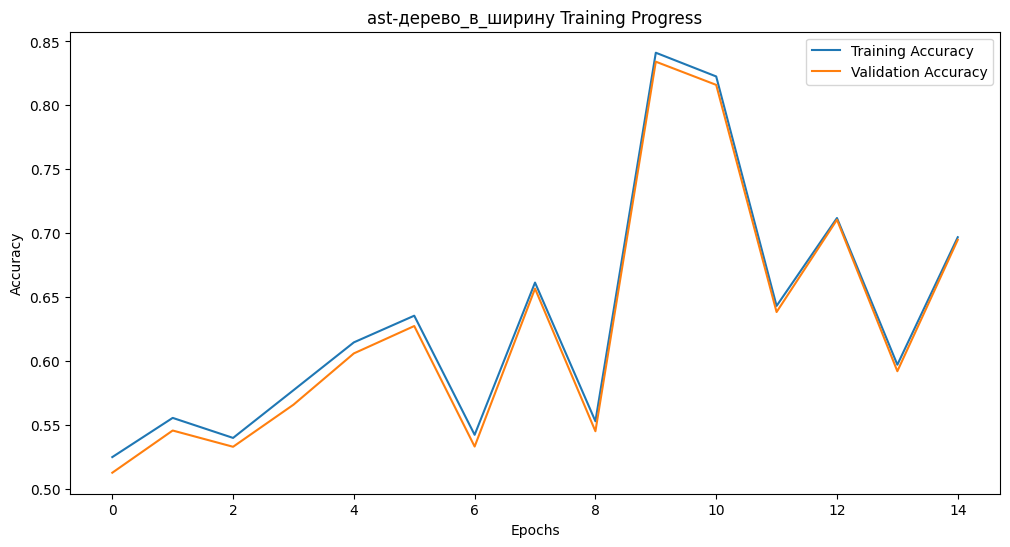

Accuracy: 0.6962481962481962
f1_score: 0.5741261099246937
ast-дерево_в_ширину


Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 657.81ba/s]


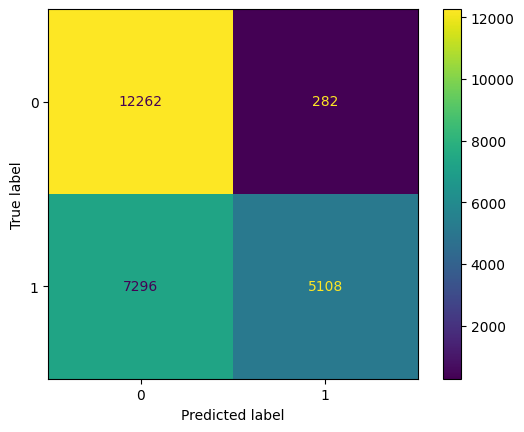

In [23]:
#классификационная голова с логированием

perceptron = Perceptron(tol=None, max_iter=1)

best_accuracy = 0
tol = 0.01
no_improvement = 0
max_no_improvement = 5

train_acc = []
val_acc = []

for epoch in range(1000):
    perceptron.partial_fit(X_train, y_train, classes=np.unique(y_train))
    
    y_pred_eval = perceptron.predict(X_eval)
    accuracy_eval = accuracy_score(y_eval, y_pred_eval)
    
    y_pred_train = perceptron.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    
    if accuracy_eval > best_accuracy + tol:
        best_accuracy = accuracy_eval
        no_improvement = 0
    else:
        no_improvement += 1
        
    train_acc.append(accuracy_train)
    val_acc.append(accuracy_eval)
    
    print('Epoch:', epoch+1, 'Validation Accuracy:', accuracy_eval)
    
    if no_improvement >= max_no_improvement:
        print('Early stopping triggered at epoch', epoch+1)
        break
    
    
title = "ast-дерево_в_ширину"
    
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ast-дерево_в_ширину Training Progress')
plt.legend()
plt.savefig('acc_график'+title+'prj.jpg')
plt.show()
    


y_pred = perceptron.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(title)
Dataset.from_dict({"orig":y_test, "prediction": y_pred}).to_json("ast-дерево_в_ширину_prediction.json")
plt.savefig('confusion_matrix_'+title+'prj.jpg')

Creating json from Arrow format: 100%|██████████| 25/25 [00:00<00:00, 1135.67ba/s]


Accuracy: 0.6028940195606862
f1_score: 0.3505735824319895
json_w_code_ch_EStop


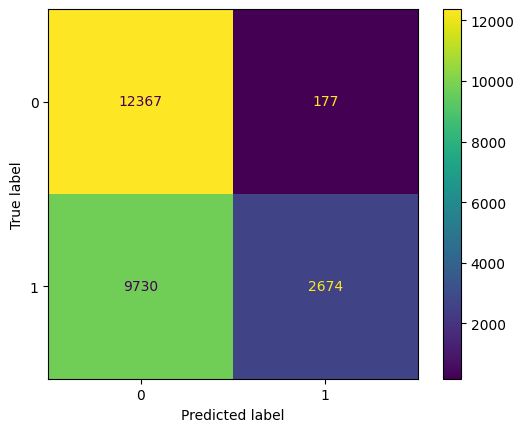

In [25]:
perceptron = Perceptron(early_stopping=True, tol=5, max_iter=1000)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_test)
Dataset.from_dict({"prediction": y_pred}).to_json("json_w_code_EStop_predicitons.json")
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
f1 = f1_score(y_test, y_pred)
print('f1_score:', f1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(cm).plot()
title = "json_w_code_ch_EStop"
print(title)
plt.savefig('confusion_matrix_'+title+'.jpg')

In [26]:
def get_table(ch_1, ch_2):
    a = 0
    b = 0
    c = 0
    d = 0
    for i in range(len(ch_1)):
        if ch_1[i] == 1 and ch_2[i] == 1:
            a += 1
        elif ch_1[i] == 1 and ch_2[i] == 0:
            b += 1
        elif ch_1[i] == 0 and ch_2[i] == 1:
            c += 1
        elif ch_1[i] == 0 and ch_2[i] == 0:
            d += 1
            
    return [[a,b],[c,d]]
    

In [27]:
from statsmodels.stats.contingency_tables import mcnemar 

def tt(ch_1, ch_2):
	result = mcnemar(get_table(ch_1, ch_2), exact=True)
	print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
	alpha = 0.05
	if result.pvalue > alpha:
		print('H0 не отвергнута, аугментация не эффективна')
	else:
		print('H0 отвергнута, аугментация эффективна')
	print(f"p-value: {result.pvalue}")

In [30]:
simple_code = load_dataset("json", data_files="Experiments_1\\bert\простой_код\простой_код_prediction.json")["train"]
print(simple_code)
simple_code_result = []
for el in simple_code:
    if el["prediction"] == el["orig"]:
        simple_code_result.append(1)
    else:
        simple_code_result.append(0)
print(simple_code_result)

Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1

In [31]:
sexp_code = load_dataset("json", data_files="ast-дерево_в_ширину_prediction.json")["train"]
print(sexp_code)
sexp_code_result = []
for el in sexp_code:
    if el["prediction"] == el["orig"]:
        sexp_code_result.append(1)
    else:
        sexp_code_result.append(0)
print(sexp_code_result)

Dataset({
    features: ['orig', 'prediction'],
    num_rows: 24948
})
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1

In [33]:
print(tt(simple_code_result, sexp_code_result))

statistic=1303.000, p-value=0.000
H0 отвергнута, аугментация эффективна
p-value: 1.981769829461486e-213
None
